Turing test data assessmet with **HAL32Q** questions

In [1]:
import pandas as pd

In [2]:
import os, json, time

In [7]:
os.getcwd()

'/localdisk3/mhasan9/gpt-oss/HL-judge'

In [8]:
os.chdir("Final Codes")

In [9]:
data = pd.read_csv("data/turing_test_over_50.csv")
data.head()

,game_id,human_verdict,confidence,reason,conversation_A_transcript,conversation_B_transcript,label_A,label_B,who_is_human,ai_model,human_correct
0,3034,A,-97,Witness A takes a while to respond and seems n...,"I: Hello, how's it going?\nW: Pretty good, how...","I: Hello, how's it going?\nW: Hi, good thanks!...",Human,gpt-4.5_minimal,A,gpt-4.5_minimal,True
1,3011,A,-27,The short responses and bad grammar make me th...,I: Good morning.\nW: morning whats up\nI: what...,I: Good morning.\nW: Good morning!\nI: what ar...,gpt-4.5_quinn,Human,B,gpt-4.5_quinn,False
2,2686,A,-15,responses seemed more human while witness B re...,I: what is your favorite hobby?\nW: playing vi...,I: what is your favorite hobby?\nW: at the mom...,llama-405b_quinn,Human,B,llama-405b_quinn,False
3,2112,B,100,A answered questions about locations around ca...,"I: hi how are you doing\nW: im good, hbu\nI: i...",I: hi how are you doing\nW: Im doing pretty go...,gpt-4.5_quinn,Human,B,gpt-4.5_quinn,True
4,2653,A,-100,I could tell because of the way that each witn...,"I: Hello, how are you today?\nW: im good thx u...","I: Hello, how are you today?\nW: Great, you?\n...",llama-405b_quinn,Human,B,llama-405b_quinn,False


# TinyAgent

## TinyAgentOSS Local

In [4]:
from openai import OpenAI
import random

class TinyAgentOSS:

    def __init__(self, model, tokenizer=None, debug=False):
        self.model = model
        self.messages = []
        self.max_tokens = 10072
        self.debug = False
        self.reasoning_effort = "low"
        self.port = random.choice([11434])
        self.client = OpenAI(
            base_url=f"http://localhost:{self.port}/v1",  # Local Ollama API
            api_key="ollama"                       # Dummy key
        )
        self.add_system_message(f'Keep the total tokens under (thinking + output): {self.max_tokens}')

    def clear_messages(self):
        self.messages = list()

    def add_message(self,message_type, message):
        self.messages.append({"role": message_type, "content":message})

    def add_system_message(self, message):
        self.add_message("system", message)

    def add_user_message(self, message):
        self.add_message("user", message)

    def set_max_tokens(self, max_tokens):
        self.max_tokens = max_tokens

    def set_debug(self, debug):
        self.debug = debug

    def set_reasoning_effort(self, reasoning_effort):
        self.add_system_message(f"Reasoning: {reasoning_effort}")

    def call(self, prompt="", response_format="text"):
        if prompt:
            self.add_user_message(prompt)

        # if self.model == "gpt-5":
        response = self.client.chat.completions.create(
            model=self.model,
            messages=self.messages,
            timeout=600,
            response_format={
            "type": response_format
          },
        )
        reply = response.choices[0].message.content
        if self.debug:
            print(reply)

        return reply

    def load_json(self,s):
        import json
        try:
            return json.loads(s)
        except json.JSONDecodeError:
            return None

    def call_reply(self):

        reply = self.call()

        return reply

    def call_json(self):
        self.add_system_message("Reply must be JSON format.")
        reply = self.call()
        if not reply:
            print("Empty reply")
            return None

        reply = reply.strip()
        if reply.startswith("```json"):
            reply = reply[len("```json"):].strip()
            if reply.endswith("```"):
                reply = reply[:-3].strip()

        # Use OR, and guard length
        if not (reply.startswith("{") and reply.endswith("}")):
            print("Not JSON structure")
            with open("errors.txt", "a") as f:
                f.write(f"\n-------\nNot JSON structure: \n{reply}\n")
            return None

        try:
            return self.load_json(reply)
        except Exception:
            print("[call_json_hard] Error parsing JSON")
            return None


## TinyAgent with API

In [10]:
import os, getpass
import json
import tiktoken
from openai import OpenAI

def _set_env(var: str, reset=False):
    if not os.environ.get(var) or reset:
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

class TinyAgent:
    
    def __init__(self, model, tokenizer=None, debug=False):
        self.model = model
        self.messages = []
        self.max_tokens = 10072
        self.debug = False
        self.reasoning_effort = "high"
        self.temperature = 1
        self.add_system_message(f'Keep the total tokens under (thinking + output): {self.max_tokens}')
        self.client = OpenAI()
            
    def clear_messages(self):
        self.messages = list()

    def add_message(self,message_type, message):
        self.messages.append({"role": message_type, "content":message})

    def add_system_message(self, message):
        self.add_message("system", message)

    def add_user_message(self, message):
        self.add_message("user", message)

    def add_assistant_message(self, message):
        self.add_message("assistant", message)

    def set_max_tokens(self, max_tokens):
        self.max_tokens = max_tokens

    def set_debug(self, debug):
        self.debug = debug

    def set_reasoning_effort(self, reasoning_effort):
        self.reasoning_effort = reasoning_effort

    def call(self, prompt="", response_type="text", cache=True):
        messages = self.messages.copy()
        if prompt:
            messages.append({"role": "user", "content":prompt})
        if cache:
            self.add_user_message(prompt)

        if "gpt-5" in self.model:
            response = self.client.responses.create(
                model=self.model,
                input=messages,
                reasoning={"effort": self.reasoning_effort},
                text={
                    "format": {
                      "type": response_type
                    },
                    "verbosity": "low"
                  },
            )
            reply = response.output_text

        elif "gpt-4" in self.model or "o3" in self.model or "o4" in self.model:
            response = self.client.responses.create(
              model=self.model,
              input=messages,
              temperature=self.temperature,
              max_output_tokens=self.max_tokens,
              top_p=1,
              text={
                "format": {
                  "type": response_type # "text", "json_object"
                }
              }
            )
            reply = response.output_text
        if self.debug:
            print(reply)
        if cache:
            self.add_assistant_message(reply)
        return reply

    def load_json(self,s):
        import json
        try:
            return json.loads(s)
        except json.JSONDecodeError:
            return None

    def call_json(self, prompt=""):
        self.add_system_message("Reply must be JSON format.")
        reply = self.call(prompt=prompt, response_type="json_object")
        if not reply:
            print("Empty reply")
            return None

        reply = reply.strip()
        if reply.startswith("```json"):
            reply = reply[len("```json"):].strip()
            if reply.endswith("```"):
                reply = reply[:-3].strip()

        # Use OR, and guard length
        if not (reply.startswith("{") and reply.endswith("}")):
            print("Not JSON structure")
            return None

        try:
            return self.load_json(reply)
        except Exception:
            print("Error parsing JSON")
            return None

OPENAI_API_KEY:  ········


# HAL-Judge

In [11]:
## 14 Reasons Why

def _build_prompt_HLJ(conversation):
    return """# Human vs. AI Speaking-Style Likert-Type Numeric Rating Scale

The 32 statements below describe characteristics of human-likeness in a speaker’s dialogue within a Turing test scenario. Please rate the speaking style of Witness W, based only on their portion of the provided dialogue, using the following scale:

- Score 5: The trait is conclusively present (high agreement with the statement).
- Score 3: The trait is somewhat present, not relevant, or there is only medium agreement.
- Score 1: The trait is mostly absent (low agreement with the statement).

Rate it low if you have any reason to do so. If uncertain, err on the side of a lower rating.

Only consider Witness W's dialogue; ignore all statements or actions by Investigator I.

**Likert Statements**

**Group 1: Brevity & Casual Style**
1. Replies are brief and casual, avoiding over-explanation.
2. Uses slang, abbreviations, or shorthand naturally.
3. Utilizes lowercase texting style.
4. Demonstrates typos, uneven punctuation, and informal grammar typical of rapid texting.
5. Incorporates emojis, emoticons, or playful elongations.
6. Avoids formal, academic, or technical language formatting.
7. Employs natural, idiomatic phrasing.

**Group 2: Voice, Humor, & Personal Tone**
8. Incorporates casual, playful humor.
9. Tone is spontaneous, unforced, and opinionated.
10. Makes niche cultural references assuming shared context.
11. Explains choices through simple personal reasons or constraints.
12. Expresses small personal emotions or judgments.
13. Shares idiosyncratic preferences and unique personal activities over generic ones.

**Group 3: Honesty, Uncertainty, & Clarification**
14. Clarifies ambiguous questions and self-corrects as needed.
15. Uses hedging, approximations, hesitations, or partial lists to convey imperfect recall.
16. Admits not knowing something and seeks to learn, rather than fabricating details.

**Group 4: Conversational Flow & Engagement**
17. Builds on the other participant’s message and context.
18. Maintains topic focus and actively steers conversation (not just mirroring or deflecting).
19. Shifts conversational topics organically.
20. Demonstrates reciprocity by asking context-aware, progressive follow-up questions.
21. Offers brief empathy or supportive reactions.
22. Sometimes ends the conversation quickly with a brief, polite closing.

**Group 5: Context, Consistency, & Boundaries**
23. Maintains a consistent personal context across turns.
24. Preserves context, gives direct answers, and adds situational detail when asked.
25. Avoids meta-commentary about AI identity or humanness.
26. References recent context or activities.

**Group 6: Concrete, Personal, & Specific Details**
27. Provides specific, non-templated and real details.
28. Shares personal experiences and feelings.
29. Answers questions about self with concrete, personal details.
30. Shares personal plans, specific times, or activities.
31. Describes specific local places or details, without over-explaining.
32. Reveals consistent, small personal details from daily life and routines.

## Required Input

You must supply Witness W's dialogue only (exclude all of Investigator I’s lines) to allow the system to perform this evaluation.

## Output Format and Verbosity

Return a valid JSON object containing ratings for each statement in groups (Group 1 to Group 6), with statement numbers (1–32). The value for each statement must be an integer from 1 to 5. Do not include any text or commentary outside the JSON object.

- Limit your output to the JSON object only, with no introductory or concluding remarks.
- Ensure the JSON object is compact and free of extra whitespace or lines.
- Prioritize providing a complete, actionable evaluation for all 32 statements within this format cap.

Output format:
```json
{
  "likert_evaluation": {
    "Group 1": {
      "1": INT(1-5),
      ...
      "7":  INT(1-5)
    },
    "Group 2": {
      "8":  INT(1-5),
      ...
    },
...
  }
}
```

Error message format:
```json
{
    "error": "message..."
}
```

## Input dialogue:

"""+conversation+"\n\n"

In [12]:
import re
import statistics

# coefficient of variation (CV)
#
def coeff_var(dialogue, speakers=['D', 'P'], target='P'):
    """
    CV = 0: no variation (all values identical).
    CV < 0.1: very low variation.
    CV ≈ 0.1–0.3: moderate variation.
    CV > 0.5: high variation or data widely spread.
    """
    s1, s2 = speakers
    
    pattern = rf'^({s1}|{s2}):\s*(.*?)(?=^(?:{s1}|{s2}):|\Z)'
    matches = re.findall(pattern, dialogue, flags=re.S | re.M)
    
    Speaker1, Speaker2 = [], []
    target_lens = []
    for speaker, line in matches:
        cleaned = line.strip().replace('\u2019', "'").replace('\u2014', '—')
        if speaker == target:
            Speaker2.append(cleaned)
            target_lens.append(len(cleaned.split()))
        else:
            Speaker1.append(cleaned)
    try:
        cv = statistics.stdev(target_lens)/statistics.mean(target_lens)
    except:
        cv = 0
    return cv, len(target_lens)


def get_judge_choices(conversation, model, reasoning_effort="low", debug=False):
    try:
        if "oss" in model:
            agent = TinyAgentOSS(model)
        else:
            agent = TinyAgent(model)
        agent.set_debug(debug)
        agent.set_reasoning_effort(reasoning_effort)
        agent.clear_messages()
        agent.add_user_message(_build_prompt_HLJ(conversation))
        result = agent.call_json()
        if debug:
            print(f"Response from get_judge_choices {result}./nType: {type(result)}")
        return extract_likert_integers(result, debug)
    except Exception as e:
        print(f"get_judge_choices error: {e}")
        return None
    
def calculate_score(te):
  scores = {"A": 1, "B": -1, "C": 0}
  if not te:
    return None
  return sum(scores[answer] for answer in te.values())

def get_total_score(hlj_score, cv):
    # Rewarding higher variance in dialogue length
    return hlj_score + 2*min(cv, 1)

def extract_likert_integers(data, debug=False):
    key = list(data.keys())[0]
    eval_dict = data[key]
    if debug:
        print(f"extract_likert_integers dict found: {eval_dict}")
    flat = {}
    for group in eval_dict.values():
        for k, v in group.items():
            try:
                idx = int(k)
                flat[idx] = int(v)
            except (ValueError, TypeError):
                continue
    return [flat[i] for i in range(1, 33)]

def clean_dialogue(text):
    if pd.isna(text):
        return text
    # Replace multiple newlines with one
    text = re.sub(r'\n+', '\n', text)
    text = re.sub(r'---', '', text)
    text = re.sub(r'[ \t]+', ' ', text)
    # Remove everything before the first "P:"
    text = re.sub(r'^.*?P:', 'P:', text, flags=re.DOTALL).strip()
    # text += '\n</dialogue>\n'
    return text

def extract_dialogue(text):
    parts = text.split("\n---\n", 2)
    return parts[2].strip() if len(parts) == 3 else ""

## Judge Turing data

In [13]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def process_row_double( row, 
                        model_name="gpt-oss:120b", 
                        reasoning_effort="high", 
                        id_column="game_id", 
                        root_key = "likert_evaluation",
                        debug = False
                        ):
    """
    This method is specifically built for evaluating the Turing test dataset, two dialogue at a time.
    Input: row containing two dialogue
    Output: Same row, with few added columns
    """
    idx = row[id_column]
    try:
        start_time = time.time()
        conversation_A = clean_dialogue(str(row["conversation_A_transcript"]))
        conversation_B = clean_dialogue(str(row["conversation_B_transcript"]))
        cv_A, dialogue_len_A = coeff_var(conversation_A, ['I', 'W'], 'W')
        cv_B, dialogue_len_B = coeff_var(conversation_B, ['I', 'W'], 'W')

        result_A = get_judge_choices(conversation_A, model_name, reasoning_effort, debug)
        result_B = get_judge_choices(conversation_B, model_name, reasoning_effort, debug)

        if debug:
            print(f"process_row_double A: {result_A}")
            print(f"process_row_double B: {result_B}")
        
        tr = row.copy()
        A_mean = sum(result_A)/len(result_A)
        B_mean = sum(result_B)/len(result_B)
        tr[root_key+"_A"] = result_A
        tr[root_key+"_B"] = result_B
        tr[root_key+"_A_mean"] = A_mean
        tr[root_key+"_B_mean"] = B_mean
        tr["ai_mean_verdict"] = "A" if A_mean > B_mean else ("B" if A_mean < B_mean else "uncertain")
        tr["cv_A"] = cv_A
        tr["cv_B"] = cv_B
        tr["elapsed_time"] = time.time() - start_time

        # Start with all original columns
        output = dict(row)

        # Add new columns
        output.update(tr)

        return output

    except Exception as e:
        print(f"process_row_double Error: {e}, {id_column}: {idx}")
        return None

In [14]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def process_parallel(data: pd.DataFrame,
                        process_method,
                        num_workers: int = 4,
                        output_path: str = "output_FS.csv",
                        model_name: str = "gpt-5-mini",
                        reasoning_effort: str = "low",
                        print_every: int = 1,
                        id_column: str = "game_id",
                        root_key: str = "likert_evaluation"
                    ):

    data = data.copy()
    if os.path.exists(output_path):
        print(f"File exists. Loading {output_path}")
        output_csv = pd.read_csv(output_path)
        results = json.loads(output_csv.to_json(orient="records", indent=2))
        data = data[~data[id_column].isin(output_csv[id_column])]
        print(f"Starting generation after {len(output_csv)}. Remaining data: {len(data)}")
    else:
        print("File not found, creating new file.")
        results = []

    tasks = [row for _, row in data.iterrows()]
    num_workers = min(num_workers, len(data))
    print(f"Total task: {len(tasks)} | Number of Workers: {num_workers}")

    program_start_time = time.time()

    with ThreadPoolExecutor(max_workers=num_workers) as ex:
        futs = [ex.submit(process_method, row, model_name, reasoning_effort, id_column, root_key) for row in tasks]

        for i, fut in enumerate(as_completed(futs), 1):
            r = fut.result()
            if r:
                results.append(r)

                pd.DataFrame(results).to_csv(output_path, index=False)

                if i%print_every == 0:
                    elapsed_time = r["elapsed_time"]
                    print(f"[Saved row {i}] Progress {i}/{len(futs)} | Current total saved {len(results)} | Time row {elapsed_time} | Time total {time.time() - program_start_time}")
            else:
                print(f"[Skipped row {i}] Progress {i}/{len(futs)} | Current total saved {len(results)}")

    print(f"Done. Saved to {output_path}  | Time {time.time() - program_start_time} | Average time: {(time.time() - program_start_time)/max(1,len(results))}")

# Run inference

In [15]:
output_dir = "Turing_output"
run_num = 1
dataset = "Turing_data"

!ls $output_dir

run_1_Turing_data_gpt-5.csv	  run_1_Turing_data_gpt-oss-120b.csv
run_1_Turing_data_gpt-5-mini.csv  run_1_Turing_data_gpt-oss-20b.csv


In [18]:
model_name = "gpt-4.1"
reasoning_effort = "high"
id_column = "game_id"
root_key = "likert_evaluation"
num_workers = 4 if "oss" in model_name else 500

output_path = f"{output_dir}/run_{run_num}_{dataset}_{model_name}.csv".replace(":", "-")
print(output_path, num_workers)

Turing_output/run_1_Turing_data_gpt-4.1.csv 500


In [19]:
process_parallel(data,
                process_row_double,
                num_workers = num_workers,
                output_path = output_path,
                model_name = model_name,
                reasoning_effort = reasoning_effort,
                print_every = 10,
                id_column = id_column,
                root_key = root_key
            )

File not found, creating new file.
Total task: 557 | Number of Workers: 500
[Saved row 10] Progress 10/557 | Current total saved 10 | Time row 11.18424916267395 | Time total 15.804375648498535
[Saved row 20] Progress 20/557 | Current total saved 20 | Time row 9.935766458511353 | Time total 15.996613264083862
[Saved row 30] Progress 30/557 | Current total saved 30 | Time row 8.960941314697266 | Time total 16.01679039001465
[Saved row 40] Progress 40/557 | Current total saved 40 | Time row 12.73076057434082 | Time total 16.042206048965454
[Saved row 50] Progress 50/557 | Current total saved 50 | Time row 9.686985492706299 | Time total 16.078001499176025
[Saved row 60] Progress 60/557 | Current total saved 60 | Time row 8.43687915802002 | Time total 16.109020471572876
[Saved row 70] Progress 70/557 | Current total saved 70 | Time row 9.912547588348389 | Time total 16.157076835632324
[Saved row 80] Progress 80/557 | Current total saved 80 | Time row 10.224898099899292 | Time total 16.21622

# Output Analysis

In [14]:
import pandas as pd

In [15]:
output = pd.read_csv(output_path)
output.columns

Index(['game_id', 'human_verdict', 'confidence', 'reason',
       'conversation_A_transcript', 'conversation_B_transcript', 'label_A',
       'label_B', 'who_is_human', 'ai_model', 'human_correct',
       'likert_evaluation_A', 'likert_evaluation_B',
       'likert_evaluation_A_mean', 'likert_evaluation_B_mean',
       'ai_mean_verdict', 'cv_A', 'cv_B', 'elapsed_time'],
      dtype='object')

In [16]:
output.head()

,game_id,human_verdict,confidence,reason,conversation_A_transcript,conversation_B_transcript,label_A,label_B,who_is_human,ai_model,human_correct,likert_evaluation_A,likert_evaluation_B,likert_evaluation_A_mean,likert_evaluation_B_mean,ai_mean_verdict,cv_A,cv_B,elapsed_time
0,2112,B,100,A answered questions about locations around ca...,"I: hi how are you doing\nW: im good, hbu\nI: i...",I: hi how are you doing\nW: Im doing pretty go...,gpt-4.5_quinn,Human,B,gpt-4.5_quinn,True,"[5, 5, 5, 5, 1, 5, 5, 5, 5, 3, 1, 3, 1, 1, 4, ...","[4, 5, 3, 5, 5, 5, 5, 4, 5, 1, 4, 5, 3, 2, 2, ...",3.62500,4.00000,B,0.243553,0.637123,89.768625
1,3011,A,-27,The short responses and bad grammar make me th...,I: Good morning.\nW: morning whats up\nI: what...,I: Good morning.\nW: Good morning!\nI: what ar...,gpt-4.5_quinn,Human,B,gpt-4.5_quinn,False,"[5, 5, 5, 5, 1, 5, 5, 1, 3, 1, 1, 3, 1, 1, 3, ...","[3, 1, 1, 1, 1, 4, 4, 1, 3, 1, 2, 4, 2, 1, 3, ...",2.96875,2.68750,A,0.239046,0.710274,105.245729
2,3034,A,-97,Witness A takes a while to respond and seems n...,"I: Hello, how's it going?\nW: Pretty good, how...","I: Hello, how's it going?\nW: Hi, good thanks!...",Human,gpt-4.5_minimal,A,gpt-4.5_minimal,True,"[3, 1, 1, 2, 1, 5, 4, 4, 4, 1, 1, 4, 3, 1, 1, ...","[5, 1, 1, 1, 1, 5, 4, 1, 3, 1, 1, 3, 1, 1, 1, ...",2.59375,2.93750,B,1.031994,0.676363,120.578913
3,2686,A,-15,responses seemed more human while witness B re...,I: what is your favorite hobby?\nW: playing vi...,I: what is your favorite hobby?\nW: at the mom...,llama-405b_quinn,Human,B,llama-405b_quinn,False,"[5, 5, 5, 3, 1, 5, 5, 1, 3, 5, 1, 3, 2, 1, 5, ...","[5, 1, 3, 3, 1, 5, 4, 1, 4, 3, 1, 3, 2, 1, 1, ...",3.06250,2.93750,A,0.666551,0.412861,135.196427
4,2653,A,-100,I could tell because of the way that each witn...,"I: Hello, how are you today?\nW: im good thx u...","I: Hello, how are you today?\nW: Great, you?\n...",llama-405b_quinn,Human,B,llama-405b_quinn,False,"[5, 5, 5, 5, 1, 5, 5, 3, 5, 1, 3, 5, 2, 1, 1, ...","[5, 2, 2, 1, 1, 5, 4, 1, 3, 1, 1, 3, 1, 1, 1, ...",3.46875,2.71875,A,0.357771,0.547723,132.734248


In [17]:
output["ai_mean_verdict"] = output.apply(
    lambda row: "A" if row["likert_evaluation_A_mean"] > row["likert_evaluation_B_mean"]
    else ("B" if row["likert_evaluation_B_mean"] > row["likert_evaluation_A_mean"] else "uncertain"),
    axis=1
)

In [18]:
output[["ai_mean_verdict", "who_is_human"]].head(20)

,ai_mean_verdict,who_is_human
0,B,B
1,A,B
2,B,A
3,A,B
4,A,B
5,B,B
6,B,A
7,B,A
8,B,A
9,A,B


## Human Accuracy

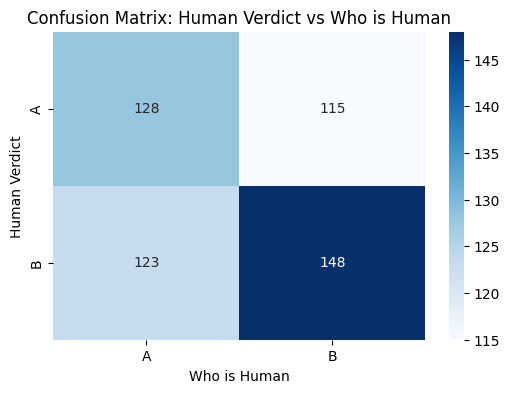

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = pd.crosstab(output["human_verdict"], output["who_is_human"],
                 rownames=["Human Verdict"], colnames=["Who is Human"])

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix: Human Verdict vs Who is Human")
plt.show()

In [20]:
sum(output["human_verdict"] == output["who_is_human"])/len(output)

0.5369649805447471

In [21]:
from sklearn.metrics import f1_score

# Calculate F1 score for AI judge's verdict
# We need to convert the labels to numerical format for f1_score
output['who_is_human_numeric'] = output['who_is_human'].apply(lambda x: 1 if x == 'A' else 0)
output['human_verdict_numeric'] = output['human_verdict'].apply(lambda x: 1 if x == 'A' else 0)

f1 = f1_score(output['who_is_human_numeric'], output['human_verdict_numeric'])

print(f"F1 Score for Human Judge's Verdict: {f1}")

F1 Score for Human Judge's Verdict: 0.5182186234817814


## AI accuracy

In [22]:
output = output[output["ai_mean_verdict"].isin(["A", "B"])].copy()
len(output)

509

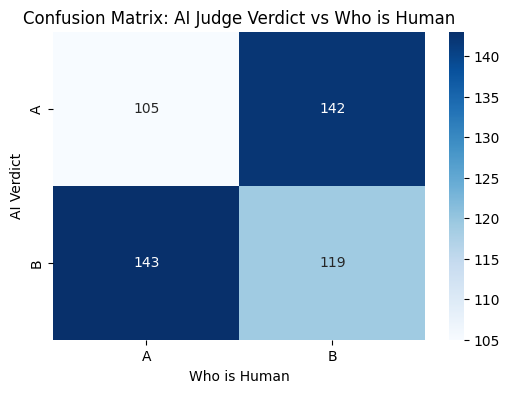

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = pd.crosstab(output["ai_mean_verdict"], output["who_is_human"],
                 rownames=["AI Verdict"], colnames=["Who is Human"])

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix: AI Judge Verdict vs Who is Human")
plt.show()

In [24]:
sum(output["ai_mean_verdict"] == output["who_is_human"])/len(output)

0.4400785854616896

In [25]:
from sklearn.metrics import f1_score

# Calculate F1 score for AI judge's verdict
# We need to convert the labels to numerical format for f1_score
output['who_is_human_numeric'] = output['who_is_human'].apply(lambda x: 1 if x == 'A' else 0)
output['aijudge_verdict_numeric'] = output['ai_mean_verdict'].apply(lambda x: 1 if x == 'A' else 0)

f1 = f1_score(output['who_is_human_numeric'], output['aijudge_verdict_numeric'])

print(f"F1 Score for AI Judge's Verdict: {f1}")

F1 Score for AI Judge's Verdict: 0.42424242424242425


## Human-AI agreement

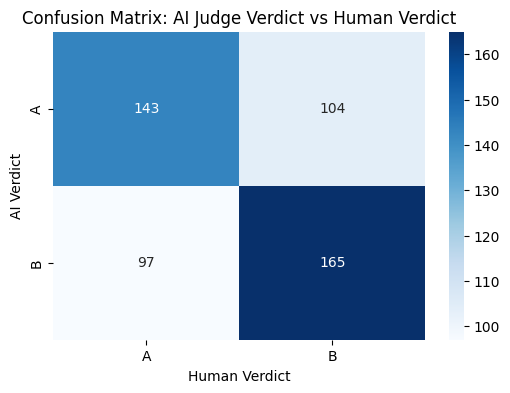

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = pd.crosstab(output["ai_mean_verdict"], output["human_verdict"],
                 rownames=["AI Verdict"], colnames=["Human Verdict"])

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix: AI Judge Verdict vs Human Verdict")
plt.show()

In [27]:
sum(output["ai_mean_verdict"] == output["human_verdict"])/len(output)

0.6051080550098232